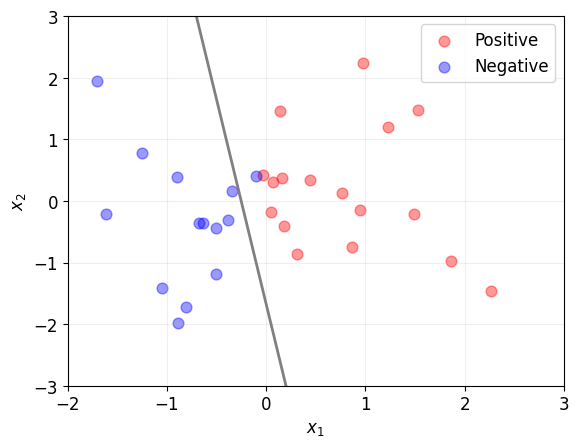

In [20]:
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
import cvxpy as cvx
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(0)

d = 2
N = 32

beta = np.random.randn(d, 1)
x = np.random.randn(N, d)
y_true = np.matmul(x, beta)
y_true[y_true >= 0] = 1
y_true[y_true < 0] = -1
y = y_true + 0.01*np.random.randn(N, 1)
label_1 = y > 0
label_0 = y <= 0
z = np.ones(N)
z = z/np.sum(z)

y[y >= 0] = 1
y[y < 0] = -1

SVMModel = svm.SVC(kernel='linear').fit(x, y.ravel())

sv = SVMModel.support_vectors_
beta = SVMModel.coef_[0]
b = SVMModel.intercept_

c = [0, 0.4471, 0.7412]

sz = 60
x1 = x[:, 0]
x2 = x[:, 1]

fig, ax = plt.subplots()
ax.scatter(x1[label_1.ravel()], x2[label_1.ravel()], sz, facecolors='r', edgecolors='r', alpha=0.4)
ax.scatter(x1[label_0.ravel()], x2[label_0.ravel()], sz, facecolors='b', edgecolors='b', alpha=0.4)
x_plot = np.arange(np.min(x1), np.max(x1), 0.1)
y_plot = -(beta[0]/beta[1]*x_plot) - b/beta[1]
ax.plot(x_plot, y_plot, linewidth=2, color='gray')
ax.legend(['Positive', 'Negative'])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim([-2, 3])
ax.set_ylim([-3, 3])
ax.grid(True, alpha=0.2)


CVX status: optimal


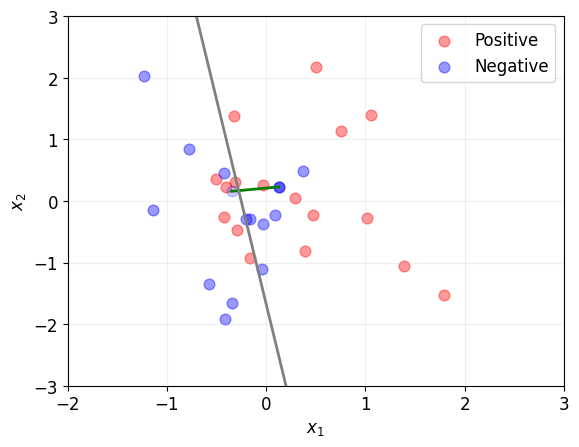

CVX status: optimal


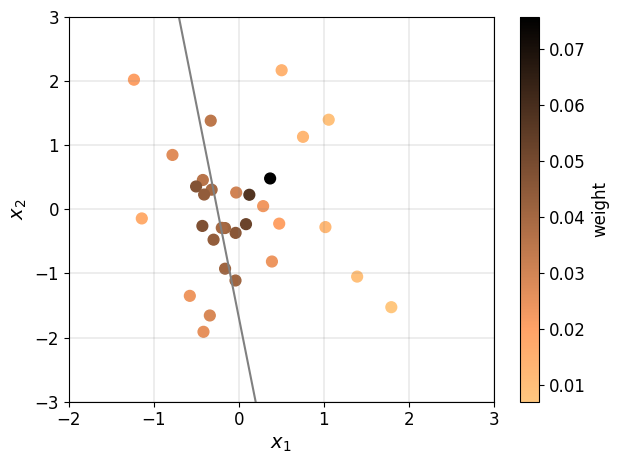

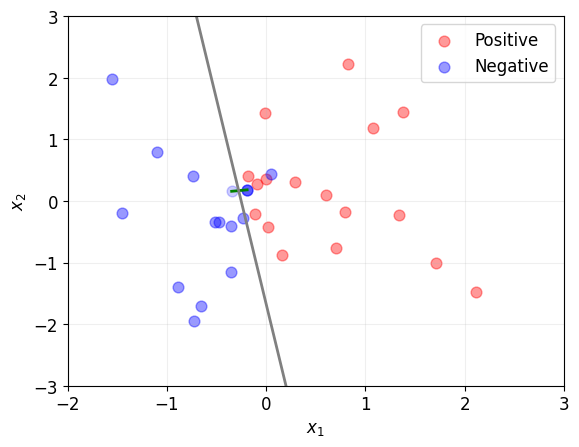

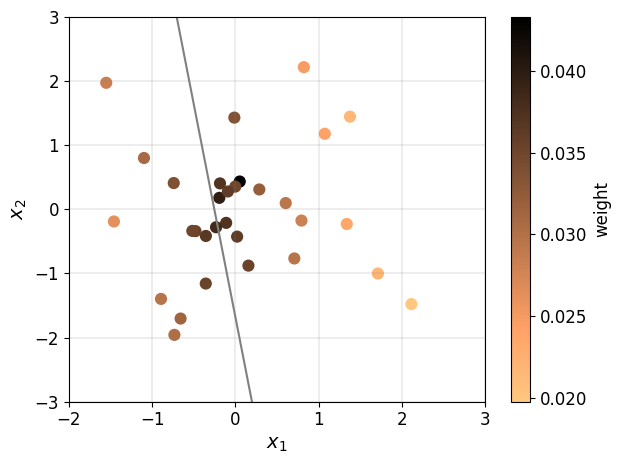

In [34]:
deltas = [0.01, 0.001]
plt.rcParams.update({"font.size": 12})
import matplotlib as mpl

for cnt, delta_ in enumerate(deltas):
    # CVX model
    delta = delta_
    lambda_var = cvx.Variable()
    t = cvx.Variable()
    eta = cvx.Variable(N)
    p = cvx.Variable(N)
    constraints = [cvx.sum(eta)/N <= lambda_var,
                eta >= 0,
                p >= 0]
    for i in range(N):
                constraints.append(
                    cvx.constraints.exponential.ExpCone(
                        p[i] - t, lambda_var, eta[i]
                    )
                )
                constraints.append(p[i] >= cvx.pos(1 - y[i] * beta.T @ x[i, :]))

    prob = cvx.Problem(cvx.Minimize(lambda_var*delta + t), constraints)
    prob.solve()

    # Check CVX status
    print('CVX status:', prob.status)
    p_opt = p.value
    lambda_opt = lambda_var.value

    x_perturb = np.zeros([N, d])
    for i in range(N):
        if np.abs(p_opt[i]) < 1e-8:
            x_perturb[i, :] = x[i, :]
        else:
            x_perturb[i, :] = x[i, :] - 0.5 / lambda_opt * y[i] * beta.T

    fig, ax = plt.subplots()

    x_new1 = x_perturb[:, 0]
    x_new2 = x_perturb[:, 1]
    ax.scatter(x_new1[label_1.ravel()], x_new2[label_1.ravel()], sz, facecolors='r', edgecolors='r', alpha=0.4)
    ax.scatter(x_new1[label_0.ravel()], x_new2[label_0.ravel()], sz, facecolors='b', edgecolors='b', alpha=0.4)
    indx = 16
    ax.scatter(x1[indx], x2[indx], sz, facecolors='b', edgecolors='b', alpha=0.2);
    ax.scatter(x_new1[indx],x_new2[indx], sz, facecolors='b', edgecolors='b', alpha=0.4)
    # plot displayment
    ax.plot([x1[indx], x_new1[indx]], [x2[indx], x_new2[indx]], linewidth=2, color='g', markersize=12)
    x_plot = np.arange(np.min(x_new1), np.max(x_new1), 0.1)
    y_plot = -(beta[0]/beta[1]*x_plot) - b/beta[1]
    ax.plot(x_plot, y_plot,linewidth=2, color='gray')
    ax.legend(['Positive', 'Negative'])
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_xlim([-2, 3])
    ax.set_ylim([-3, 3])
    ax.grid(True, alpha=0.2)

    plt.show()
    fig.savefig(
        ("results/figures/worst_case_points_{}.pdf").format(
            cnt),
        bbox_inches="tight",
    )
    for i in range(N):
        z[i] = (max(1 - y[i] * (np.dot(beta, x_perturb[i]) + b) - t.value) / lambda_opt - np.linalg.norm(x[i] - x_perturb[i])**2)
        z[i] = np.exp(z[i])

    z = z / np.sum(z)

    fig, ax = plt.subplots()
    sc = ax.scatter(x_new1, x_new2, s=sz, c=z, cmap=mpl.colormaps["copper_r"])
    plt.colorbar(sc, ax=ax, label='weight')

    x_plot = np.arange(min(x_new1), max(x_new1), 0.1)
    y_plot  = -(beta[0]/beta[1] * x_plot) - b/beta[1]

    ax.plot(x_plot, y_plot, linewidth=1.5, color=[128/255, 128/255, 128/255])

    ax.set_xlabel('$x_1$', fontsize=14)
    ax.set_ylabel('$x_2$', fontsize=14)
    # ax.set_title('$\delta=0.1$, Likelihood Perturbation', fontsize=14)

    ax.grid(True, which='both', color='grey', linewidth=0.2)
    ax.set_facecolor('w')
    ax.set_xlim([-2, 3])
    ax.set_ylim([-3, 3])

    fig.tight_layout()
    fig.savefig(
        ("results/figures/worst_case_weights_{}.pdf").format(
            cnt),
        bbox_inches="tight",
    )


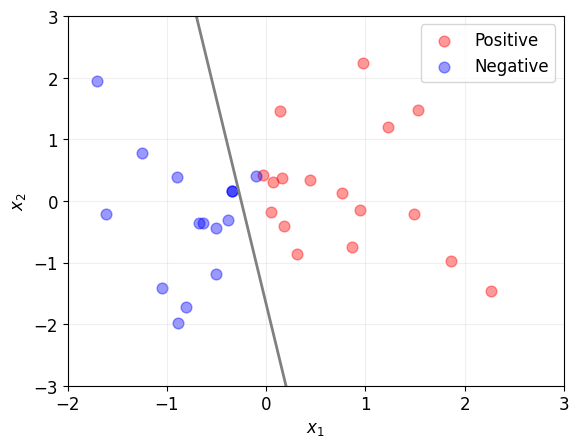

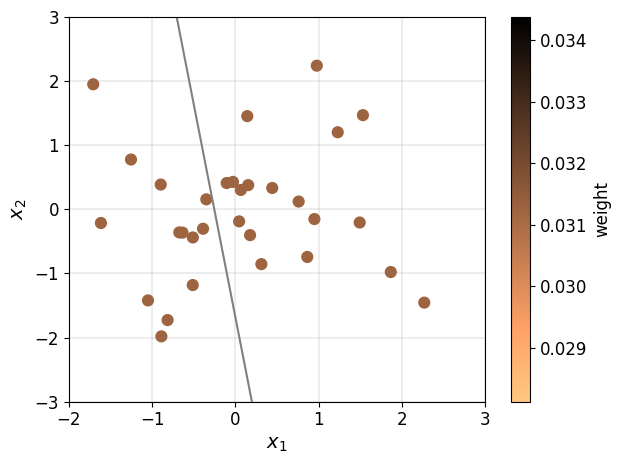

In [32]:
import matplotlib as mpl
plt.rcParams.update({"font.size": 12})
deltas = [0.01, 0.001]
plt.rcParams.update({"font.size": 12})
import matplotlib as mpl

x_perturb = x
fig, ax = plt.subplots()

x_new1 = x_perturb[:, 0]
x_new2 = x_perturb[:, 1]
ax.scatter(x_new1[label_1.ravel()], x_new2[label_1.ravel()], sz, facecolors='r', edgecolors='r', alpha=0.4)
ax.scatter(x_new1[label_0.ravel()], x_new2[label_0.ravel()], sz, facecolors='b', edgecolors='b', alpha=0.4)
indx = 16
ax.scatter(x1[indx], x2[indx], sz, facecolors='b', edgecolors='b', alpha=0.2);
ax.scatter(x_new1[indx],x_new2[indx], sz, facecolors='b', edgecolors='b', alpha=0.4)
# plot displayment
x_plot = np.arange(np.min(x_new1), np.max(x_new1), 0.1)
y_plot = -(beta[0]/beta[1]*x_plot) - b/beta[1]
ax.plot(x_plot, y_plot,linewidth=2, color='gray')
ax.legend(['Positive', 'Negative'])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim([-2, 3])
ax.set_ylim([-3, 3])
ax.grid(True, alpha=0.2)

plt.show()
fig.savefig(
    ("results/figures/worst_case_points_plain.pdf"),
    bbox_inches="tight",
)


z = np.ones_like(label_1) * 1 / x.shape[0]

fig, ax = plt.subplots()
sc = ax.scatter(x_new1, x_new2, s=sz, c=z, cmap=mpl.colormaps["copper_r"])
plt.colorbar(sc, ax=ax, label='weight')

x_plot = np.arange(min(x_new1), max(x_new1), 0.1)
y_plot  = -(beta[0]/beta[1] * x_plot) - b/beta[1]

ax.plot(x_plot, y_plot, linewidth=1.5, color=[128/255, 128/255, 128/255])

ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
# ax.set_title('$\delta=0.1$, Likelihood Perturbation', fontsize=14)

ax.grid(True, which='both', color='grey', linewidth=0.2)
ax.set_facecolor('w')
ax.set_xlim([-2, 3])
ax.set_ylim([-3, 3])

fig.tight_layout()
fig.savefig(
        ("results/figures/worst_case_weights_plain.pdf"),
        bbox_inches="tight",
    )
